In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime


transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

# Create datasets for training & validation, download if necessary
training_set = torchvision.datasets.FashionMNIST('./data', train=True, transform=transform, download=True)
validation_set = torchvision.datasets.FashionMNIST('./data', train=False, transform=transform, download=True)

BATCH_SIZE = 1000

# Create data loaders for our datasets; shuffle for training, not for validation
training_loader = torch.utils.data.DataLoader(training_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# Class labels
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

# Report split sizes
print('Training set has {} instances'.format(len(training_set)))
print('Validation set has {} instances'.format(len(validation_set)))

Training set has 60000 instances
Validation set has 10000 instances


Sandal  T-shirt/top  Dress  T-shirt/top  Sneaker  Bag  Shirt  Coat  Coat  Shirt  Trouser  Trouser  Bag  Ankle Boot  Ankle Boot  Pullover  Pullover  Dress  Trouser  Pullover  Coat  Sandal  Trouser  Shirt  Coat  Sneaker  Bag  Bag  Dress  Coat  Sandal  Trouser  Shirt  Pullover  Dress  Pullover  Coat  Shirt  Ankle Boot  Ankle Boot  Coat  Trouser  Bag  Bag  Sneaker  Sneaker  Pullover  Coat  T-shirt/top  Sneaker  Sandal  Bag  Pullover  Bag  Trouser  T-shirt/top  Sneaker  Sandal  Trouser  T-shirt/top  Bag  Dress  Dress  T-shirt/top  Coat  Dress  Trouser  Sandal  Pullover  Coat  Pullover  Ankle Boot  Trouser  Ankle Boot  Shirt  Pullover  Coat  T-shirt/top  Coat  Sneaker  Dress  Shirt  Coat  Bag  Shirt  Sandal  T-shirt/top  Pullover  Coat  Shirt  Trouser  Ankle Boot  Dress  Trouser  Coat  Coat  Shirt  Sneaker  Trouser  Sandal  Sneaker  Ankle Boot  Sneaker  Trouser  Coat  Bag  Dress  Pullover  Ankle Boot  Shirt  Shirt  Bag  Ankle Boot  Trouser  Sandal  Pullover  T-shirt/top  T-shirt/top  Sneaker

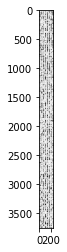

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Helper function for inline image display
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(training_loader)
images, labels = dataiter.next()

# Create a grid from the images and show them
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=True)
print('  '.join(classes[labels[j]] for j in range(BATCH_SIZE)))

In [3]:
import torch.nn as nn
import torch.nn.functional as F

# PyTorch models inherit from torch.nn.Module
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3, 3))
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=(2, 2))

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3))
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=(2, 2))

        # intialize set of fc => ReLU layer
        self.fc1 = nn.Linear(in_features=1600, out_features=800)
        self.relu3 = nn.ReLU()
        # initialize LogSoftMaxClassifier
        self.fc2 = nn.Linear(in_features=800, out_features=10)
        # self.softMax = nn.Softmax(dim=0)


    def forward(self, x):
        # pass to the first set of CONV=>RELU=>POOL layers
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)

        # pass to the first set of CONV=>RELU=>POOL layers
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        
        # flatten and pass it to the fc => RELU layers
        x = torch.flatten(x, start_dim=1)
        x = self.fc1(x)
        x = self.relu3(x)
        # pass it to the classifier to get our prediction
        x = self.fc2(x)
        # output = self.softMax(x) // Using the nn.CrossEntropyLoss, we mustn't use the softmax
        # the softmax is embedded in the CrossEntropLoss function
        output = x
        return output


model = Classifier()
print(model)

Classifier(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1600, out_features=800, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=800, out_features=10, bias=True)
)


In [4]:
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))

In [5]:
import tensorflow as tf
import tensorboard as tb
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

# helper function
def select_n_random(data, labels, n=100):
    '''
    Selects n random datapoints and their corresponding labels from a dataset
    '''
    assert len(data) == len(labels)

    perm = torch.randperm(len(data))
    return data[perm][:n], labels[perm][:n]

# select random images and their target indices
images, labels = select_n_random(training_set.data, training_set.targets)

# get the class labels for each image
class_labels = [classes[lab] for lab in labels]

# log embeddings
features = images.view(-1, 28 * 28)
writer.add_embedding(features,
                    metadata=class_labels,
                    label_img=images.unsqueeze(1))
#writer.close()

In [6]:
# helper functions

def images_to_probs(model, images):
    '''
    Generates predictions and corresponding probabilities from a trained
    network and a list of images
    '''
    output = model(images)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.numpy())
    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]


def plot_classes_preds(model, images, labels):
    '''
    Generates matplotlib Figure using a trained network, along with images
    and labels from a batch, that shows the network's top prediction along
    with its probability, alongside the actual label, coloring this
    information based on whether the prediction was correct or not.
    Uses the "images_to_probs" function.
    '''
    preds, probs = images_to_probs(model, images)
    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(12, 48))
    for idx in np.arange(4):
        ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
        matplotlib_imshow(images[idx], one_channel=True)
        ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
            classes[preds[idx]],
            probs[idx] * 100.0,
            classes[labels[idx]]),
                    color=("green" if preds[idx]==labels[idx].item() else "red"))
    return fig

In [7]:
# Loss Function
loss_fn = torch.nn.CrossEntropyLoss()

# Optimizers specified in the torch.optim package
optimizer = torch.optim.Adam(model.parameters())

In [8]:
def train_one_epoch(epoch_index, tb_writer, epoch):
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting

    for i, data in enumerate(training_loader):
        # Every data instance is an input + label pair
        inputs, labels = data

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)#.reshape([1, 10])

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        
        # if i % 60 == 59:
        #     last_loss = running_loss / 1000 # loss per batch
        #     print('  batch {} loss: {}'.format(i + 1, last_loss))
        #     tb_x = epoch_index * len(training_loader) + i + 1
        #     tb_writer.add_scalar('Loss/train', last_loss, tb_x)
        #     running_loss = 0.
        
        # ...log the running loss
        writer.add_scalar('training loss',
                        running_loss / BATCH_SIZE, # loss per batch
                        epoch * len(training_loader) + i)

        # ...log a Matplotlib Figure showing the model's predictions on a
        # random mini-batch
        writer.add_figure('predictions vs. actuals',
                        plot_classes_preds(model, inputs, labels),
                        global_step=epoch * len(training_loader) + i)

    return last_loss

In [9]:
# Initializing in a separate cell so we can easily add more epochs to the same run

epoch_number = 0
EPOCHS = 5

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch_number, writer, epoch)

    # We don't need gradients on to do reporting
    model.train(False)

    running_vloss = 0.0
    for i, vdata in enumerate(validation_loader):
        vinputs, vlabels = vdata
        voutputs = model(vinputs)
        vloss = loss_fn(voutputs, vlabels)
        running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        torch.save(model.state_dict(), model_path)

    epoch_number += 1

EPOCH 1:
LOSS train 0.0 valid 0.499167263507843
EPOCH 2:
LOSS train 0.0 valid 0.4209632873535156
EPOCH 3:


: 

In [ ]:
writer.add_graph(model, images)

In [ ]:
dataiter = iter(training_loader)
images, labels = dataiter.next()

# Create a grid from the images and show them
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=True)
writer.add_image('batch 1000 images', img_grid)